# SHAP interpret features: 
LG model trained on imbalanced ClinVar with 29 feature

In [1]:
import gzip
import pandas as pd
import numpy as np
from joblib import dump, load

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/Users/nancy/Desktop/RS_projects/data/03_ML/01_train_model/01_featureV1/01_ALLfeatures_extracted_addCLNSIG.csv',sep=';',index_col=False)
df

/var/folders/q0/2p8kfxsn7s73349btf1_g07h0000gp/T/ipykernel_56778/3969921985.py:1: DtypeWarning: Columns (32,49,50,51,54,56,58,92) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/nancy/Desktop/RS_projects/data/03_ML/01_train_model/01_featureV1/01_ALLfeatures_extracted_addCLNSIG.csv',sep=';',index_col=False)


,CLNSIG,CADD,AF_ESP,AF_EXAC,AF_TGP,Frq,GNOMADAF,GNOMADAF_popmax,Hom,ORIGIN,...,SpliceAI_pred_DP_AG,SpliceAI_pred_DP_AL,SpliceAI_pred_DP_DG,SpliceAI_pred_DP_DL,SpliceAI_pred_DS_AG,SpliceAI_pred_DS_AL,SpliceAI_pred_DS_DG,SpliceAI_pred_DS_DL,SpliceAI_pred_SYMBOL,genomic_superdups_frac_match
0,Uncertain_significance,26.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,-30.0,11.0,10.0,-30.0,0.01,0.00,0.09,0.00,SAMD11,NaN
1,Likely_benign,13.420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,7.0,-34.0,6.0,42.0,0.00,0.02,0.03,0.00,SAMD11,NaN
2,Likely_benign,31.000,NaN,NaN,NaN,0.00056,0.000414,0.000195,NaN,1.0,...,41.0,-47.0,-7.0,44.0,0.00,0.01,0.06,0.00,SAMD11,NaN
3,Uncertain_significance,28.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,10.0,-47.0,34.0,-14.0,0.00,0.00,0.03,0.02,SAMD11,NaN
4,Likely_benign,11.380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,-35.0,-50.0,12.0,24.0,0.00,0.00,0.01,0.00,SAMD11,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468907,Benign,7.587,NaN,NaN,NaN,0.00070,NaN,NaN,5.0,1.0,...,25.0,35.0,0.0,16.0,0.00,0.00,0.00,0.00,USP9Y,NaN
1468908,Uncertain_significance,23.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1468909,Benign,11.200,0.00614,0.00589,0.00243,0.00671,NaN,NaN,48.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1468910,Uncertain_significance,21.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# data preprocessing

In [3]:
""" 1. choose featuresV1"""

featureV1 = ['CLNSIG','CADD', 'AF_TGP', 'Frq', 'IMPACT','GNOMADAF_popmax', 'Hom', 'ORIGIN',
       'SPIDEX', 'SWEGENAF', 'Consequence', 'BIOTYPE', 'SIFT',
       'PolyPhen', 'MES-SWA_acceptor_alt', 'MES-SWA_acceptor_diff',
       'MES-SWA_donor_alt', 'MES-SWA_donor_diff', 'MaxEntScan_alt',
       'MaxEntScan_diff', 'GERP++_RS', 'REVEL_score',
       'phastCons100way_vertebrate', 'phyloP100way_vertebrate', 'LoFtool',
       'pLI_gene_value', 'SpliceAI_pred_DS_AG', 'SpliceAI_pred_DS_AL',
       'SpliceAI_pred_DS_DG', 'SpliceAI_pred_DS_DL']         # keep CLNSIG,

df_1 = df[featureV1]



""" 2. only remove missing target """
# for some features with fewer missing
# drop_nan_features = ['CLNSIG','CADD','Consequence','IMPACT','BIOTYPE','MES-SWA_acceptor_alt','MES-SWA_acceptor_diff',
# 'MES-SWA_donor_alt','MES-SWA_donor_diff','pLI_gene_value']

drop_nan_features = ['CLNSIG']
df_1 = df_1.dropna(subset=drop_nan_features)

In [4]:
""" 3. deal with target feature """
# """  CLNSIG: tansfer to 4 classes__ benign,pathogenic,uncertain,others
# NOTE:
# (only count name before |)   explanation-- https://www.ncbi.nlm.nih.gov/clinvar/docs/clinsig/#clinsig_scv

# 1. pathogenic: Pathogenic, Pathogenic/Likely_pathogenic, Likely_pathogenic
# 2. benign: Likely_benign, Benign, Benign/Likely_benign
# 3. uncertain: Uncertain_significance, 
# 4. others: Uncertain_risk_allele, risk_factor, protective, other, not_provided, Likely_risk_allele, drug_response, Conflicting_interpretations_of_pathogenicity, confers_sensitivity, associatio, Affects

df_1 = df_1.copy()
df_1['CLNSIG'] = df_1['CLNSIG'].replace(['Uncertain_significance|_risk_factor', 'Uncertain_significance|_other', 'Uncertain_significance|_drug_response','Uncertain_significance|_association','Uncertain_significance|_Affects','Uncertain_significance'], 'uncertain')
df_1['CLNSIG'] = df_1['CLNSIG'].replace(['Pathogenic|_risk_factor','Pathogenic|_protective','Pathogenic|_other','Pathogenic|_drug_response|_other','Pathogenic|_drug_response','Pathogenic|_confers_sensitivity','Pathogenic|_association','Pathogenic|_Affects','Pathogenic/Likely_risk_allele','Pathogenic/Likely_pathogenic|_risk_factor','Pathogenic/Likely_pathogenic|_other','Pathogenic/Likely_pathogenic|_drug_response','Pathogenic/Likely_pathogenic','Pathogenic','Likely_pathogenic|_risk_factor','Likely_pathogenic|_other','Likely_pathogenic|_drug_response','Likely_pathogenic|_association','Likely_pathogenic|_Affects','Likely_pathogenic,_low_penetrance','Likely_pathogenic'], 'pathogenic')
df_1['CLNSIG'] = df_1['CLNSIG'].replace(['Likely_benign|_risk_factor','Likely_benign|_other','Likely_benign|_drug_response|_other','Likely_benign','Benign|_risk_factor','Benign|_protective','Benign|_other','Benign|_drug_response','Benign|_confers_sensitivity','Benign|_association|_confers_sensitivity','Benign|_association','Benign/Likely_benign|_risk_factor','Benign/Likely_benign|_other|_risk_factor','Benign/Likely_benign|_other','Benign/Likely_benign|_drug_response|_other','Benign/Likely_benign|_drug_response','Benign/Likely_benign|_association','Benign/Likely_benign','Benign'], 'benign')
df_1['CLNSIG'] = df_1['CLNSIG'].replace(['Uncertain_risk_allele|_risk_factor','Uncertain_risk_allele','risk_factor','protective','protective|_risk_factor','other', 'not_provided','Likely_risk_allele','drug_response|_risk_factor','drug_response|_other','drug_response','Conflicting_interpretations_of_pathogenicity|_risk_factor','Conflicting_interpretations_of_pathogenicity|_protective','Conflicting_interpretations_of_pathogenicity|_other|_risk_factor','Conflicting_interpretations_of_pathogenicity|_other','Conflicting_interpretations_of_pathogenicity|_drug_response|_other','Conflicting_interpretations_of_pathogenicity|_drug_response','Conflicting_interpretations_of_pathogenicity|_association|_risk_factor','Conflicting_interpretations_of_pathogenicity|_association','Conflicting_interpretations_of_pathogenicity','confers_sensitivity','association|_risk_factor','association_not_found','association','Affects|_risk_factor','Affects|_association','Affects'], 'others')

# only keep benign & pathogenic
df_1 = df_1.loc[df_1['CLNSIG'].isin(['benign','pathogenic'])]

# label encoder
map_clnsig={'pathogenic':1,'benign':0}
df_1['CLNSIG']=df_1['CLNSIG'].map(lambda s: map_clnsig.get(s) if s in map_clnsig else s)
# df_1["CLNSIG"].unique()

In [5]:
"""4.2  keep imbalance classes """

# split
from sklearn.model_selection import train_test_split

X, y = df_1.iloc[:, 1:], df_1.iloc[:, 0]
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                    test_size=0.3,
                    random_state=42,
                    stratify=y)

/Users/nancy/miniconda3/envs/bioinfo/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
""" 5. features engineering: transformer"""
## only for training data, no care about target 'CLNSIG', total 29 features

from sklearn.compose import make_column_transformer
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from category_encoders import BinaryEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

## numerical feature group 1 : replace missing with mean;  scaling/standardization

numeric_feature_1 = ['MES-SWA_acceptor_alt','MES-SWA_acceptor_diff','MES-SWA_donor_alt','MES-SWA_donor_diff','MaxEntScan_alt','MaxEntScan_diff','GERP++_RS',
    'phastCons100way_vertebrate','phyloP100way_vertebrate']



## numerical feature group 2 : replace missing with 0;  scaling/standardization
numeric_feature_2 = ['CADD','AF_TGP', 'Frq', 'GNOMADAF_popmax', 'Hom',
       'SWEGENAF','LoFtool','pLI_gene_value','SpliceAI_pred_DS_AL',
       'SpliceAI_pred_DS_DG','SpliceAI_pred_DS_DL']



## numerical feature group 3: add missing indicator; replace missing with 0 and ; scaling/standardization
numeric_feature_3 = ['SPIDEX','REVEL_score','SpliceAI_pred_DS_AG']



## categorical ordinal feature group 4: add missing indicator for ['SIFT','PolyPhen']; replace missing with 'missing_value' string; OrdinalEncoder
categori_oridinal_feature_4 =['Consequence','IMPACT','SIFT','PolyPhen']

# ordinal features' order: left to right will be from 0 to length-1
with open('variant_consequences.txt','r') as f:             # get the 'variant_consequences order' lst: descending severity
    order_conseq=[line.rstrip("\n") for line in f] 
    order_conseq.reverse()

ordinal_features = [
    'Consequence',
    'IMPACT',
    'SIFT',
    'PolyPhen']
# 0 is the missing value will be replaced by
ordinal_ordering = [
    order_conseq,
    ['MODIFIER','LOW','MODERATE','HIGH'],
    ['tolerated_low_confidence','tolerated','deleterious_low_confidence','deleterious'],
    ['unknown','benign','possibly_damaging','probably_damaging']
    ]


## categorical nominal feature group 5: replace missing with 0 in ['ORIGIN'], with ''missing_value' in ['BIOTYPE'];  BinaryEncoder
categori_nominal_feature_5 = ['ORIGIN','BIOTYPE']  #,'BIOTYPE'



numeric_feature_1_transformer =make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

numeric_feature_2_transformer =make_pipeline(
    SimpleImputer(strategy='constant',fill_value=0),
    StandardScaler()
)

numeric_feature_3_transformer =make_pipeline(
    SimpleImputer(strategy='constant',fill_value=0),
    StandardScaler()
)

categori_oridinal_feature_4_transformer =make_pipeline(
    SimpleImputer(strategy='constant',fill_value=None),  # If None, fill_value will be 0 when imputing numerical data and “missing_value” for strings
    OrdinalEncoder(categories=ordinal_ordering, handle_unknown='use_encoded_value', unknown_value = -1)       # the unknown 'missing_value' string will be enocoded as '-1'
)

categori_oridinal_feature_5_transformer =make_pipeline(
    SimpleImputer(strategy='constant',fill_value=None),  
    BinaryEncoder()                                # add new columns, throw the original columns automaticly, 
)


preprocessor = make_column_transformer(
    (numeric_feature_1_transformer, numeric_feature_1),
    (numeric_feature_2_transformer, numeric_feature_2 ),
    (MissingIndicator(), numeric_feature_3 + categori_oridinal_feature_4[2:]),   # add new missing indicators for feature3 + ['SIFT','PolyPhen'] without originial columns,  here: total add 5 indicator columns
    (numeric_feature_3_transformer, numeric_feature_3),  
    (categori_oridinal_feature_4_transformer, categori_oridinal_feature_4),
    (categori_oridinal_feature_5_transformer, categori_nominal_feature_5),                                                    
    # (categori_oridinal_feature_5_transformer, categori_nominal_feature_5[1:])   # for checking: how many ori and biotype derived features seperately; must use [1:] formate, and see the `'BIOTYPE` first, and then can get `origin`
    # remainder='passthrough'                                                   # so here for `BIOTYPE` derived new: 5   ,  `Origin` new: 6 
)

## total features after preprocessor: 43


In [8]:
## get features name after preprocessor

col1 = numeric_feature_1 + numeric_feature_2

col2 = ['miss_SPIDEX', 'miss_REVEL_score', 'miss_SpliceAI_pred_DS_AG', 'miss_SIFT', 'miss_PolyPhen']

col3 = numeric_feature_3 + categori_oridinal_feature_4

col4 = ['ORIGIN_0', 'ORIGIN_1', 'ORIGIN_2', 'ORIGIN_3', 'ORIGIN_4', 'ORIGIN_5', 'BIOTYPE_0','BIOTYPE_1','BIOTYPE_2','BIOTYPE_3','BIOTYPE_4']

cols = col1 + col2 + col3 + col4     ## get all columns's names after preprocessing
len(cols)



43

In [9]:
cols

['MES-SWA_acceptor_alt',
 'MES-SWA_acceptor_diff',
 'MES-SWA_donor_alt',
 'MES-SWA_donor_diff',
 'MaxEntScan_alt',
 'MaxEntScan_diff',
 'GERP++_RS',
 'phastCons100way_vertebrate',
 'phyloP100way_vertebrate',
 'CADD',
 'AF_TGP',
 'Frq',
 'GNOMADAF_popmax',
 'Hom',
 'SWEGENAF',
 'LoFtool',
 'pLI_gene_value',
 'SpliceAI_pred_DS_AL',
 'SpliceAI_pred_DS_DG',
 'SpliceAI_pred_DS_DL',
 'miss_SPIDEX',
 'miss_REVEL_score',
 'miss_SpliceAI_pred_DS_AG',
 'miss_SIFT',
 'miss_PolyPhen',
 'SPIDEX',
 'REVEL_score',
 'SpliceAI_pred_DS_AG',
 'Consequence',
 'IMPACT',
 'SIFT',
 'PolyPhen',
 'ORIGIN_0',
 'ORIGIN_1',
 'ORIGIN_2',
 'ORIGIN_3',
 'ORIGIN_4',
 'ORIGIN_5',
 'BIOTYPE_0',
 'BIOTYPE_1',
 'BIOTYPE_2',
 'BIOTYPE_3',
 'BIOTYPE_4']

#  train and fit model
C = 10

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

lr = LogisticRegression(max_iter=2000, C=10, random_state= 42)

X_train_proce = preprocessor.fit_transform(X_train)

lr.fit(X_train_proce,y_train)



LogisticRegression(C=10, max_iter=2000, random_state=42)

In [11]:
## preprocessing X_test
X_test_proce = preprocessor.transform(X_test)

# shap: for explain features and models

maybe use it after feature selection, it can be used to interpret our model

https://github.com/slundberg/shap ;

For  linear  models,  if  we  assume  input  feature  independence  (Equation  11),  SHAP  values  can  be 
approximated  directly from the  model’s  weight  coefﬁcients.

SHAP values is given to represent the feature

In [12]:
import shap

## Explain the linear model
explainer = shap.LinearExplainer(lr, X_train_proce, feature_dependence="independent")
shap_values = explainer.shap_values(X_test_proce)

/Users/nancy/miniconda3/envs/bioinfo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


In [13]:
shap_values.shape

(237256, 43)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


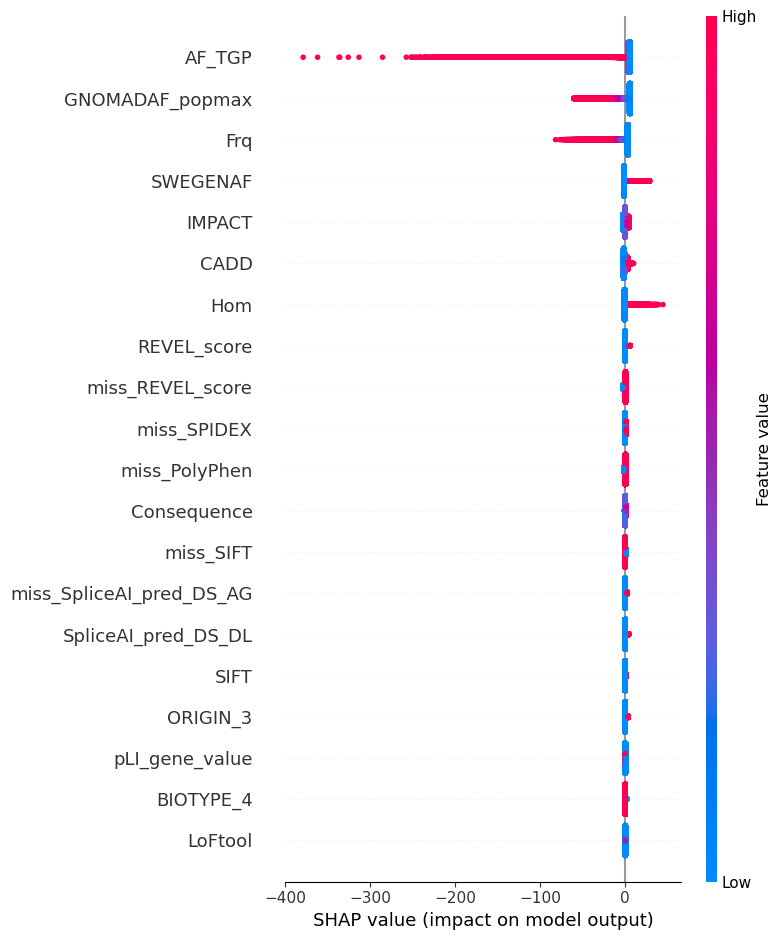

In [14]:
## Summarize the effect of all the features
shap.summary_plot(shap_values, X_test_proce, feature_names=cols)

## The plot shows the most important features for predicting the class. It also shows the direction of how it’s going to drive the prediction.

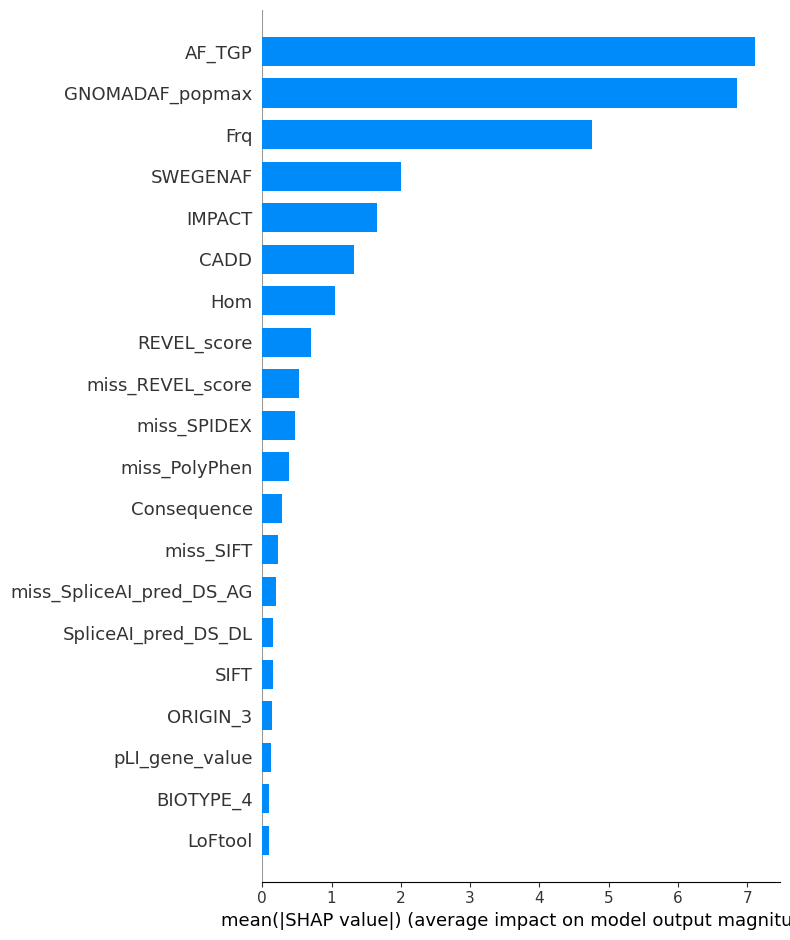

In [15]:
## Global feature importance using SHAP

shap.summary_plot(shap_values, X_test_proce, feature_names=cols,plot_type="bar")

In [16]:
values = np.abs(shap_values).mean(0)  # mean of shapely values in each column
shap_value_features = pd.DataFrame(data=values, index=cols, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)

shap_value_features
# len(shap_value_features)

,SHAP
AF_TGP,7.117710
GNOMADAF_popmax,6.851345
Frq,4.760988
SWEGENAF,2.003141
IMPACT,1.656401
CADD,1.319265
Hom,1.057141
REVEL_score,0.702695
miss_REVEL_score,0.531814
miss_SPIDEX,0.467352
